In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

In [2]:
# Load the dataset
data_height = pd.read_csv("../Trait_Extraction/Results_CSV/height_df.csv") # Replace with your file path
data_height['timestamp'] = data_height['timestamp'].str.replace('_', ':')
data_height['timestamp'] = pd.to_datetime(data_height['timestamp'], format='%Y-%m-%d %H:%M:%S')
height_columns = [col for col in data_height.columns if col.startswith('height_')]

def clean(data_column, alpha=0.1):
    return data_column.ewm(alpha=alpha, adjust=False).mean()

alpha = 0.1
data = pd.DataFrame({'timestamp': data_height['timestamp']})

for col in height_columns:
    if col in data_height.columns:
        data[col] = clean(data_height[col], alpha=alpha)
        

Rex Consistency Metrics: {'correlation_mean': 0.9597892016141488, 'correlation_std': 0.025766783889698486, 'pattern_difference_pvalue': 0.9999999999999989, 'mean_coefficient_variation': 0.49651476564821456, 'patterns_consistent': True}
Rouxai Consistency Metrics: {'correlation_mean': 0.9750105344676061, 'correlation_std': 0.018786345846541177, 'pattern_difference_pvalue': 1.0, 'mean_coefficient_variation': 0.3041575926347306, 'patterns_consistent': True}


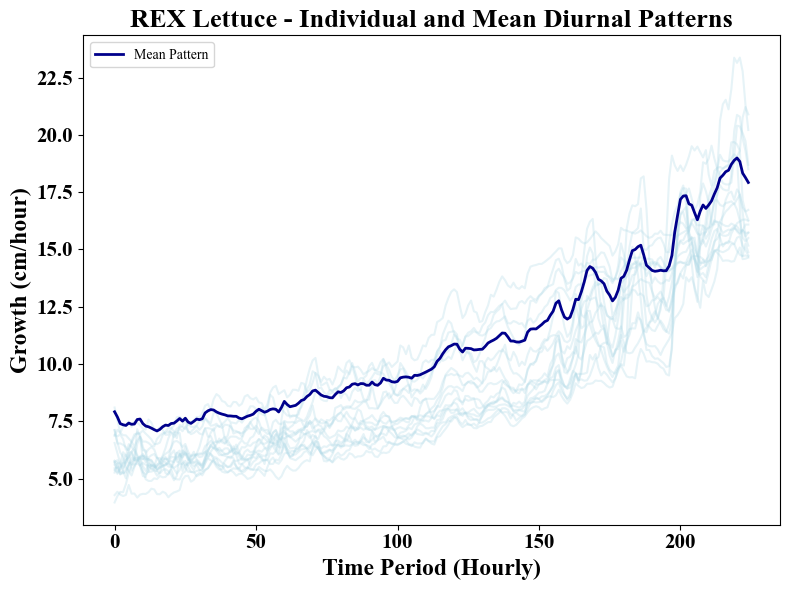

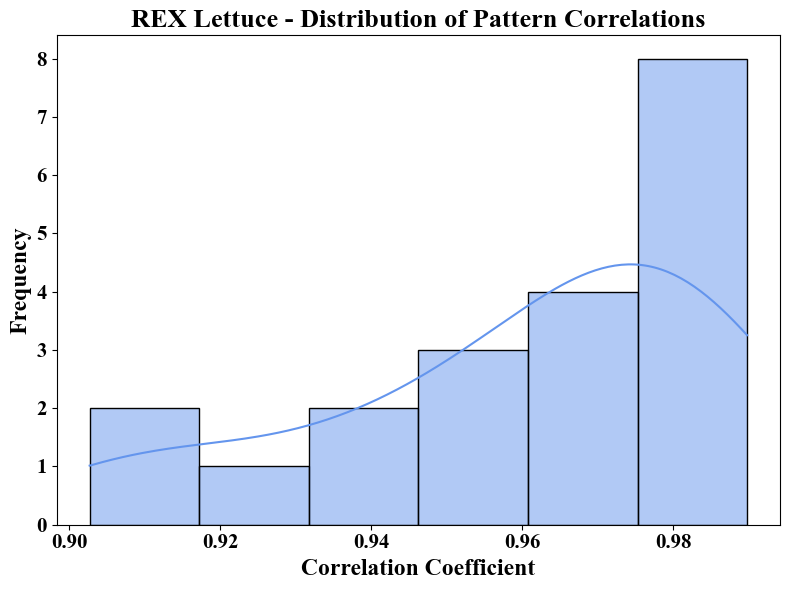

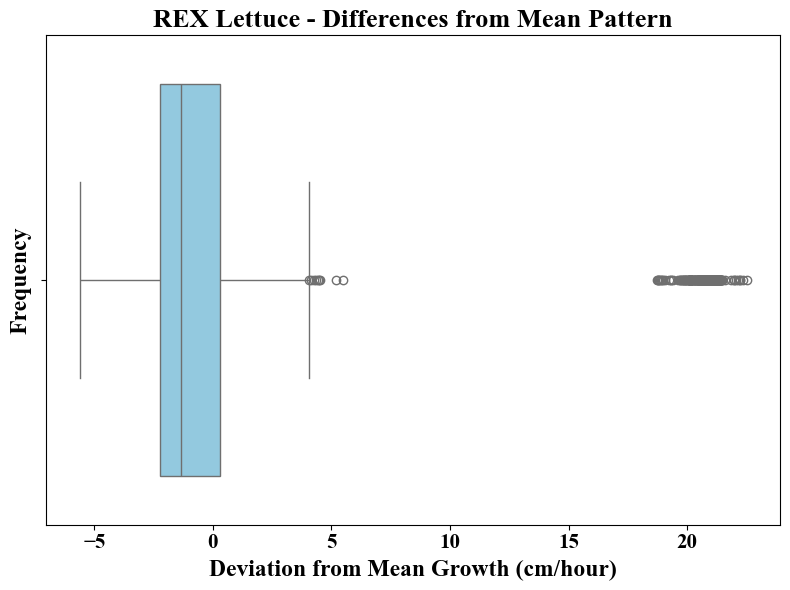

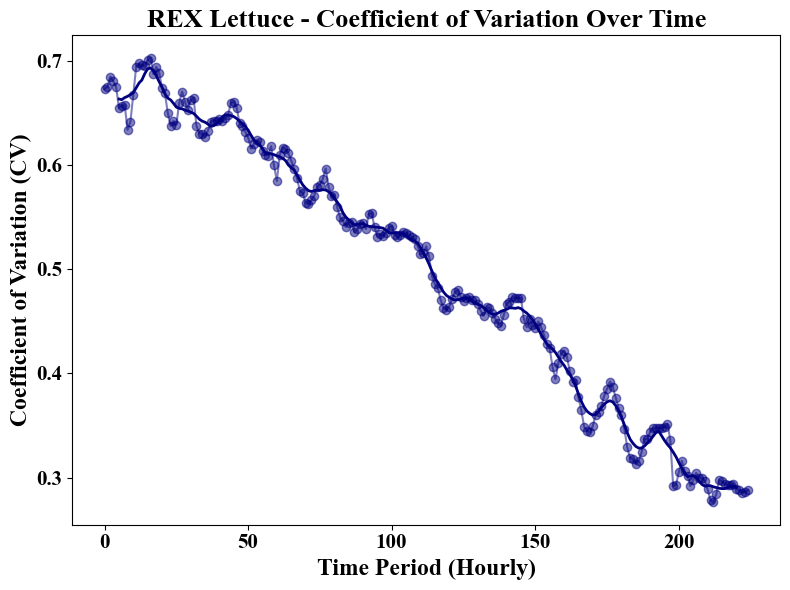

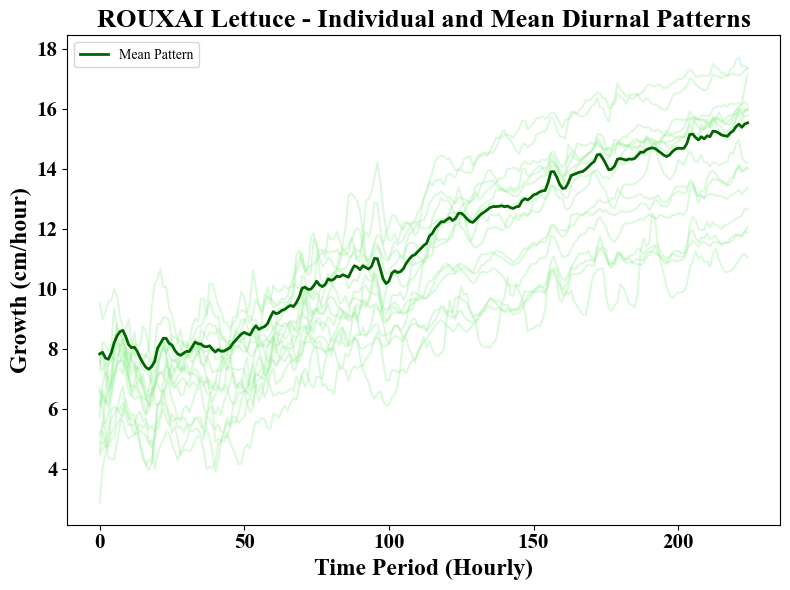

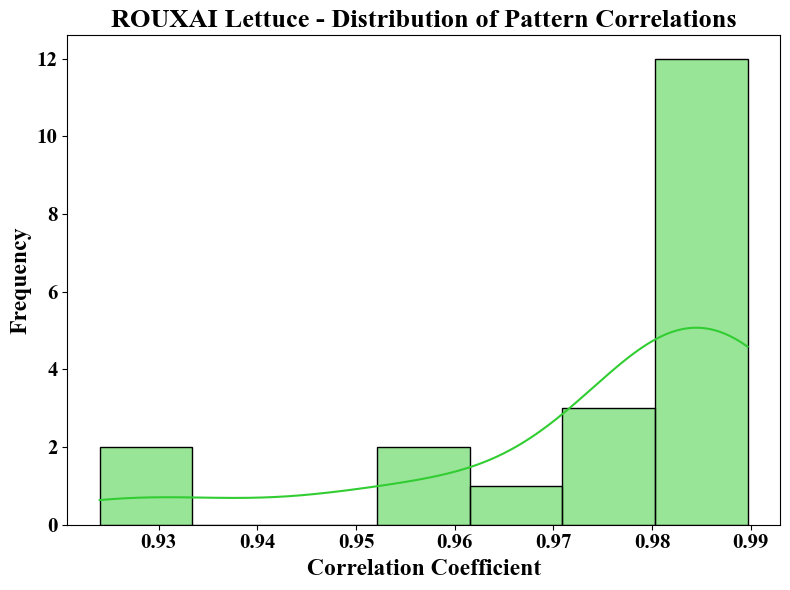

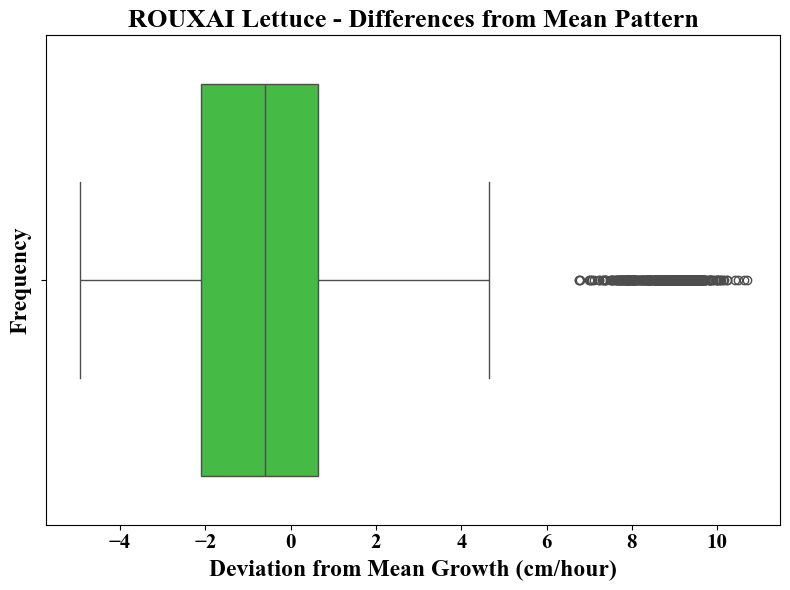

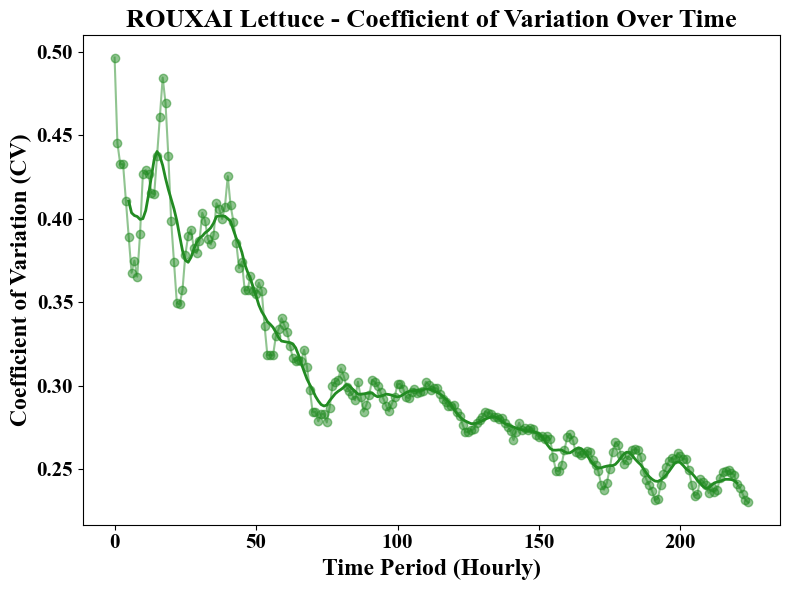

In [3]:
def process_data(data, sample_id=1):
    data = data.dropna()
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data = data.groupby(pd.Grouper(key='timestamp', freq='h')).mean().reset_index()
    
    ids = [i for i in range(20*(sample_id-1), 20*sample_id)]
    timepoints = data['timestamp'].unique()
    
    df = {
        "time_point": [],
        "growth": [],
        "lettuce_id": []
    }
    
    for tpt in timepoints:
        series = data[data['timestamp'] == tpt]
        for idx in ids:
            try:
                value = series[f"height_{idx}"].item()
                df["time_point"].append(pd.Timestamp(tpt))
                df["growth"].append(value)
                df["lettuce_id"].append(idx)
            except:
                continue
    df = pd.DataFrame(df)
    return df

def smooth_series(series, window=10):
    """Smooth a series using a rolling window."""
    return series.rolling(window=window, center=True).mean()

def analyze_diurnal_variations(data, cultivar_name='REX', time_periods=24, consistency_threshold=0.05):
    data = data.dropna().copy()  
    
    # Ensure data is properly formatted
    if not all(col in data.columns for col in ['lettuce_id', 'time_point', 'growth']):
        raise ValueError("Data must contain 'lettuce_id', 'time_point', and 'growth' columns")
    
    # Group measurements into time periods
    tidxs = data["time_point"].unique()
    for i, tid in enumerate(tidxs):
        data.loc[data["time_point"] == tid, "time_group"] = i  # f"Period_{i}"
    
    # Calculate mean pattern
    mean_pattern = data.groupby('time_group')['growth'].mean()
    
    # For each lettuce, calculate correlation with mean pattern and test differences
    correlations = []
    pattern_differences = []
    
    for lettuce in data['lettuce_id'].unique():
        lettuce_pattern = data[data['lettuce_id'] == lettuce].groupby('time_group')['growth'].mean()
        
        # Ensure that the lettuce_pattern aligns with mean_pattern
        lettuce_pattern = lettuce_pattern.reindex(mean_pattern.index)
        
        # Correlation with mean pattern
        corr, _ = stats.pearsonr(mean_pattern, lettuce_pattern)
        correlations.append(corr)
        
        # Calculate differences from mean pattern
        differences = lettuce_pattern - mean_pattern
        pattern_differences.extend(differences)
    
    # Test if differences from mean pattern are significant
    _, diff_pvalue = stats.ttest_1samp(pattern_differences, 0)
    patterns_consistent = diff_pvalue > consistency_threshold
    
    # Calculate coefficient of variation for each time point
    cv_by_timepoint = data.groupby('time_group')['growth'].agg(lambda x: np.std(x)/np.mean(x) if np.mean(x) != 0 else 0)
    mean_cv = cv_by_timepoint.mean()
    consistency_metrics = {
        'correlation_mean': np.mean(correlations),
        'correlation_std': np.std(correlations),
        'pattern_difference_pvalue': diff_pvalue,
        'mean_coefficient_variation': mean_cv,
        'patterns_consistent': patterns_consistent
    }
    
    color_schemes = {
        'REX': {
            'individual': '#ADD8E6',    # Light Blue
            'mean': '#00008B',          # Dark Blue
            'histogram': '#6495ED',     # Cornflower Blue
            'boxplot': '#87CEEB',       # Sky Blue
            'cv': '#000080'             # Navy
        },
        'ROUXAI': {
            'individual': '#90EE90',    # Light Green
            'mean': '#006400',          # Dark Green
            'histogram': '#32CD32',     # Lime Green
            'boxplot': '#32CD32',       # Lime Green
            'cv': '#228B22'             # Forest Green
        }
    }
    
    colors = color_schemes.get(cultivar_name.upper(), color_schemes['REX'])
    plt.rcParams['font.family'] = 'Times New Roman'
    
    # --- Plot 1: Individual and Mean Diurnal Patterns ---
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    for lettuce in data['lettuce_id'].unique():
        lettuce_data = data[data['lettuce_id'] == lettuce]
        lettuce_growth = lettuce_data.groupby('time_group')['growth'].mean()

        if lettuce_growth.iloc[0] <= 10:
            ax1.plot(lettuce_growth, 
                     alpha=0.3, 
                     color=colors['individual'])
    
    # Plot mean pattern
    ax1.plot(mean_pattern, 
             color=colors['mean'], 
             linewidth=2, 
             label='Mean Pattern')
    
    ax1.set_title(f'{cultivar_name} Lettuce - Individual and Mean Diurnal Patterns', fontsize=19, fontweight='bold')
    ax1.set_xlabel('Time Period (Hourly)', fontsize=17, fontweight='bold')
    ax1.set_ylabel('Growth (cm/hour)', fontsize=17, fontweight='bold')
    ax1.tick_params(axis='both', which='major', labelsize=15)
    for label in ax1.get_xticklabels() + ax1.get_yticklabels():
        label.set_fontweight('bold')
    ax1.legend()
    
    fig1.tight_layout()
    plt.savefig(f'diurnal_variation_{cultivar_name.upper()}_individual_mean.png', dpi=600, bbox_inches='tight')
    #plt.close(fig1)  # Close the figure to free memory
    
    # --- Plot 2: Correlation Distribution ---
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    
    sns.histplot(correlations, ax=ax2, kde=True, color=colors['histogram'])
    ax2.set_title(f'{cultivar_name} Lettuce - Distribution of Pattern Correlations', fontsize=19, fontweight='bold')
    ax2.set_xlabel('Correlation Coefficient', fontsize=17, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=17, fontweight='bold')
    ax2.tick_params(axis='both', which='major', labelsize=15)
    for label in ax2.get_xticklabels() + ax2.get_yticklabels():
        label.set_fontweight('bold')

    fig2.tight_layout()
    plt.savefig(f'diurnal_variation_{cultivar_name.upper()}_correlation_distribution.png', dpi=600, bbox_inches='tight')
    #plt.close(fig2)  # Close the figure to free memory
    
    # --- Plot 3: Differences from Mean Pattern ---
    fig3, ax3 = plt.subplots(figsize=(8, 6))
    sns.boxplot(x=pd.DataFrame(pattern_differences)[0], ax=ax3, color=colors['boxplot'])
    ax3.set_title(f'{cultivar_name} Lettuce - Differences from Mean Pattern', fontsize=19, fontweight='bold')
    ax3.set_xlabel('Deviation from Mean Growth (cm/hour)', fontsize=17, fontweight='bold')
    ax3.set_ylabel('Frequency', fontsize=17, fontweight='bold')
    ax3.tick_params(axis='both', which='major', labelsize=15)
    for label in ax3.get_xticklabels() + ax3.get_yticklabels():
        label.set_fontweight('bold')

    fig3.tight_layout()
    plt.savefig(f'diurnal_variation_{cultivar_name.upper()}_differences.png', dpi=600, bbox_inches='tight')
    #plt.close(fig3)  # Close the figure to free memory
    
    # --- Plot 4: Coefficient of Variation Over Time ---
    fig4, ax4 = plt.subplots(figsize=(8, 6))
    smoothed_cv = smooth_series(cv_by_timepoint, window=10)
    ax4.plot(cv_by_timepoint, color=colors['cv'], marker='o', linestyle='-', alpha=0.5)
    ax4.plot(smoothed_cv, color=colors['cv'], linewidth=2, label='Smoothed CV (Window=10)')
    ax4.set_title(f'{cultivar_name} Lettuce - Coefficient of Variation Over Time', fontsize=19, fontweight='bold')
    ax4.set_xlabel('Time Period (Hourly)', fontsize=17, fontweight='bold')
    ax4.set_ylabel('Coefficient of Variation (CV)', fontsize=17, fontweight='bold')
    ax4.tick_params(axis='both', which='major', labelsize=15)
    for label in ax4.get_xticklabels() + ax4.get_yticklabels():
        label.set_fontweight('bold')
    
    # Tight layout and save
    fig4.tight_layout()
    plt.savefig(f'diurnal_variation_{cultivar_name.upper()}_cv_over_time.png', dpi=600, bbox_inches='tight')
    #plt.close(fig4)  # Close the figure to free memory
    return consistency_metrics

# Example usage for Rex and Rouxai cultivars
# Process data for Rex (sample_id=1)
rex_data = process_data(data, sample_id=1)
rex_results = analyze_diurnal_variations(rex_data, cultivar_name='REX')

# Process data for Rouxai (sample_id=2)
rouxai_data = process_data(data, sample_id=2)
rouxai_results = analyze_diurnal_variations(rouxai_data, cultivar_name='ROUXAI')

# Print the results for verification
print("Rex Consistency Metrics:", rex_results)
print("Rouxai Consistency Metrics:", rouxai_results)